## ノック61: 輸送最適化問題

In [15]:
import pandas as pd
import numpy as np
from itertools import product
from pulp import LpVariable, lpSum, value  # 組み合わせ問題で用いるライブラリ
from ortoolpy import model_min, addvars, addvals  # pulpと一緒に使うライブラリ

In [16]:
# データ読み込み
df_tc = pd.read_csv("trans_cost.csv", index_col="工場")
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")
print(df_tc)
print(df_demand)
print(df_supply)

# 初期設定
np.random.seed(1)
nw = len(df_tc.index)
nf = len(df_tc.columns)
pr = list(product(range(nw), range(nf)))
print("nw=",nw)
print("nf=",nf)
print(pr)

    F1  F2  F3  F4
工場                
W1  10  10  11  27
W2  18  21  12  14
W3  15  12  14  12
   F1  F2  F3  F4
0  28  29  31  25
   W1  W2  W3
0  35  41  42
nw= 3
nf= 4
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [17]:
# 数理モデル作成

# m1として最小化を行うモデルを定義
m1 = model_min()

# 目的関数をm1に定義。df_tcとv1の要素の積の和で目的関数を定義
v1 = {(i,j):LpVariable("v%d_%d"%(i,j),lowBound=0) for i,j in pr}
m1 += lpSum(df_tc.iloc[i][i]*v1[i,j] for i,j in pr)

# 制約条件を設定
for i in range(nw):
  m1 += lpSum(v1[i,j] for j in range(nf)) <= df_supply.iloc[0][i]  # 供給可能量を超えないように設定
for j in range(nf):
  m1 += lpSum(v1[i,j] for i in range(nw)) >= df_demand.iloc[0][j]  # 需要量を下回らないように設定

# 変数が最適化され、最適な輸送コストを算出する
m1.solve()

print(v1)
print(m1)

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}
NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 10*v0_2 + 10*v0_3 + 21*v1_0 + 21*v1_1 + 21*v1_2 + 21*v1_3 + 14*v2_0 + 14*v2_1 + 14*v2_2 + 14*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous



In [18]:
# 輸送コスト計算(数理モデルで解いた結果の確認。v1から参照する)
df_tr_sol = df_tc.copy()
total_cost = 0
for k,x in v1.items():
  i,j = k[0],k[1]
  df_tr_sol.iloc[i][j] = value(x)
  total_cost += df_tc.iloc[i][j] * value(x)

print(df_tr_sol)
print("総輸送:"+str(total_cost))

    F1  F2  F3  F4
工場                
W1   6  29   0   0
W2   5   0  31   0
W3  17   0   0  25
総輸送:1367.0


## ノック62: 最適輸送ルートをネットワークで確認

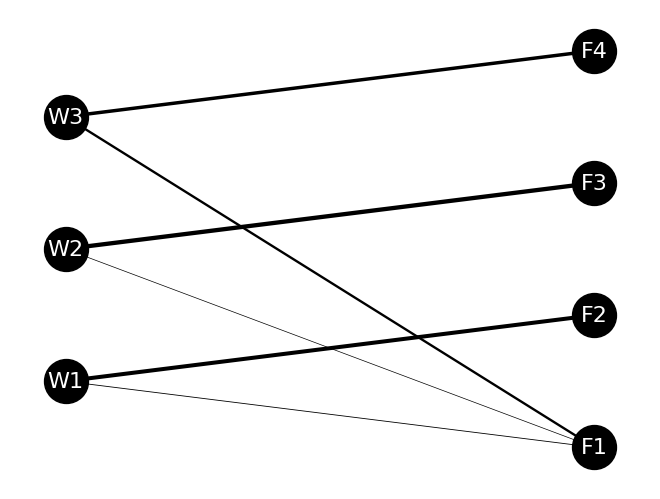

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# データ読み込み
df_tr = df_tr_sol.copy()
df_pos = pd.read_csv("trans_route_pos.csv")

# グラフオブジェクトの作成
G = nx.Graph()

# 頂点の設定
for i in range(len(df_pos.columns)):
  G.add_node(df_pos.columns[i])

# 辺の設定&エッジの重みのリスト化
num_pre = 0
edge_weights = []
size = 0.1
for i in range(len(df_pos.columns)):
  for j in range(len(df_pos.columns)):
    if not (i==j):
      # 辺の追加
      G.add_edge(df_pos.columns[i], df_pos.columns[j])
      # エッジの重みの追加
      if num_pre < len(G.edges):
        num_pre = len(G.edges)
        weight = 0
        if (df_pos.columns[i] in df_tr.columns)and(df_pos.columns[j] in df_tr.index):
          if df_tr[df_pos.columns[i]][df_pos.columns[j]]:
            weight = df_tr[df_pos.columns[i]][df_pos.columns[j]]*size
        elif (df_pos.columns[j] in df_tr.columns)and(df_pos.columns[i] in df_tr.index):
          if df_tr[df_pos.columns[j]][df_pos.columns[i]]:
            weight = df_tr[df_pos.columns[j]][df_pos.columns[i]]*size
        edge_weights.append(weight)

# 座標の設定
pos = {}
for i in range(len(df_pos.columns)):
  node = df_pos.columns[i]
  pos[node] = (df_pos[node][0],df_pos[node][1])

# 描画
nx.draw(G, pos, with_labels=True, font_size=16, node_size=1000, node_color="k", font_color="w", width=edge_weights)

# 表示
plt.show()

##ノック63: 最適輸送ルートが制約条件内に収まっているか確認

In [20]:
# 確認
import pandas as pd
import numpy as np

# データ読み込み
df_demand = pd.read_csv("demand.csv")
df_supply = pd.read_csv("supply.csv")
print(df_demand)
print(df_supply)

# 制約条件計算関数
# 需要側
def condition_demand(df_tr,df_demand):
  flag = np.zeros(len(df_demand.columns))
  for i in range(len(df_demand.columns)):
    temp_sum = sum(df_tr[df_demand.columns[i]])
    if (temp_sum >= df_demand.iloc[0][i]):
      flag[i] = 1
  return flag

# 供給側
def condition_supply(df_tr,df_supply):
  flag = np.zeros(len(df_supply.columns))
  for i in range(len(df_supply.columns)):
    temp_sum = sum(df_tr.loc[df_supply.columns[i]])
    if temp_sum <= df_supply.iloc[0][i]:
      flag[i] = 1
  return flag

print(df_tr_sol)

print("需要条件計算結果："+str(condition_demand(df_tr_sol,df_demand)))
print("供給条件計算結果："+str(condition_supply(df_tr_sol,df_supply)))

   F1  F2  F3  F4
0  28  29  31  25
   W1  W2  W3
0  35  41  42
    F1  F2  F3  F4
工場                
W1   6  29   0   0
W2   5   0  31   0
W3  17   0   0  25
需要条件計算結果：[1. 1. 1. 1.]
供給条件計算結果：[1. 1. 1.]


## ノック64: 生産計画に関するデータの読み込み

In [21]:
df_material = pd.read_csv("product_plan_material.csv", index_col="製品")
print("df_material")
print(df_material)
df_profit = pd.read_csv("product_plan_profit.csv", index_col="製品")
print("df_profit")
print(df_profit)
df_stock = pd.read_csv("product_plan_stock.csv", index_col="項目")
print("df_stock")
print(df_stock)
df_plan = pd.read_csv("product_plan.csv", index_col="製品")
print("df_plan")
print(df_plan)

df_material
     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
df_profit
      利益
製品      
製品1  5.0
製品2  4.0
df_stock
    原料1  原料2  原料3
項目               
在庫   40   80   50
df_plan
      生産量
製品       
製品1    16
製品2     0


## ノック65: 利益計算関数を作成

In [22]:
# 利益計算する関数を作り、これを目的関数として最大化を検討する
def product_plan(df_profit,df_plan):
  profit = 0
  for i in range(len(df_profit.index)):
    for j in range(len(df_plan.columns)):
      profit += df_profit.iloc[i][j]*df_plan.iloc[i][j]
  return profit

print("総利益："+str(product_plan(df_profit,df_plan)))

総利益：80.0


## ノック66: 生産最適化問題を解く

In [23]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

df = df_material.copy()
inv = df_stock
print("df")
print(df)
print("inv")
print(inv)

df
     原料1  原料2  原料3
製品                
製品1    1    4    3
製品2    2    4    1
inv
    原料1  原料2  原料3
項目               
在庫   40   80   50


In [24]:
# model_max を宣言
m = model_max()

# 変数v1を製品数と同じ次元で定義。変数v1と製品毎の利益の積の和によって目的関数を定義
v1 = {(i):LpVariable("v%d"%(i), lowBound=0) for i in range(len(df_profit))} 
m += lpSum(df_profit.iloc[i]*v1[i] for i in range(len(df_profit)))

# それぞれの原料の使用量が在庫を超えないように定義
for i in range(len(df_material.columns)):
  m += lpSum(df_material.iloc[j,i]*v1[j] for j in range(len(df_profit))) <= df_stock.iloc[:,i]

# 問題を解く
m.solve()

# 結果の確認
df_plan_sol = df_plan.copy()
for k,x in v1.items():
  df_plan_sol.iloc[k] = value(x)
print("df_plan_sol")
print(df_plan_sol)
print("総利益:"+str(value(m.objective)))

df_plan_sol
      生産量
製品       
製品1    15
製品2     5
総利益:95.0


## ノック67: 最適生産計画が制約条件内に収まっているか確認

In [25]:
# 生産最適化の内容を検証する(使用量と在庫のチェック)
def condition_stock(df_plan,df_material,df_stock):
  flag = np.zeros(len(df_material.columns))
  for i in range(len(df_material.columns)):
    temp_sum = 0
    for j in range(len(df_material.index)):
      temp_sum += df_material.iloc[j][i]*float(df_plan.iloc[j])
    if (temp_sum <= float(df_stock.iloc[0][i])):
      flag[i] = 1
    print(df_material.columns[i]+" 使用量:"+str(temp_sum)+", 在庫:"+str(float(df_stock.iloc[0][i])))
  return flag

print("制約条件計算結果:"+str(condition_stock(df_plan_sol,df_material,df_stock)))

原料1 使用量:25.0, 在庫:40.0
原料2 使用量:80.0, 在庫:80.0
原料3 使用量:50.0, 在庫:50.0
制約条件計算結果:[1. 1. 1.]


C:\Users\nao23\AppData\Local\Temp\ipykernel_10224\4098853514.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  temp_sum += df_material.iloc[j][i]*float(df_plan.iloc[j])


## ノック68: ロジスティクスネットワーク問題を解く

In [26]:
# 輸送コストと製造コストが最小になるように定式化
# つまり、目的関数として輸送コストと製造コストの和を、
# 制約条件として各商店での販売数が需要数を上回る事を考える

製品 = list("AB")
需要地 = list("PQ")
工場 = list("XY")
レーン = (2,2)

# 輸送費表(前提条件)
tbdi = pd.DataFrame(((j,k) for j in 需要地 for k in 工場), columns=["需要地","工場"])
tbdi["輸送費"] = [1,2,3,1]
print(tbdi)

# 需要表(前提条件)
tbde = pd.DataFrame(((j,i) for j in 需要地 for i in 製品), columns=["需要地","製品"])
tbde["需要"] = [10,10,20,20]
print(tbde)

# 生産表(前提条件)
tbfa = pd.DataFrame(((k,l,i,0,np.inf) for k, nl in zip(工場,レーン) for l in range(nl) for i in 製品),
                    columns=["工場","レーン","製品","下限","上限"])
tbfa["生産費"] = [1, np.nan, np.nan, 1, 3, np.nan, 5, 3]
tbfa.dropna(inplace=True)
tbfa.loc[4, "上限"] = 10
print(tbfa)

from ortoolpy import logistics_network
_, tbdi2, _ = logistics_network(tbde, tbdi, tbfa)
print(tbfa)
print(tbdi2)

  需要地 工場  輸送費
0   P  X    1
1   P  Y    2
2   Q  X    3
3   Q  Y    1
  需要地 製品  需要
0   P  A  10
1   P  B  10
2   Q  A  20
3   Q  B  20
  工場  レーン 製品  下限    上限  生産費
0  X    0  A   0   inf  1.0
3  X    1  B   0   inf  1.0
4  Y    0  A   0  10.0  3.0
6  Y    1  A   0   inf  5.0
7  Y    1  B   0   inf  3.0
  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000022  20.0
3  X    1  B   0   inf  1.0  v000023  10.0
4  Y    0  A   0  10.0  3.0  v000024  10.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026  20.0
  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0


## ノック69: 最適ネットワークにおける輸送コストとその内訳計算

In [27]:
# 輸送費の列と最適輸送量を格納するValXの列を掛け合わせて輸送コスト計算
print(tbdi2)
trans_cost = 0
for i in range(len(tbdi2.index)):
  trans_cost += tbdi2["輸送費"].iloc[i]*tbdi2["ValX"].iloc[i]
print("総輸送コスト:"+str(trans_cost))

  需要地 工場  輸送費 製品     VarX  ValX
0   P  X    1  A  v000014  10.0
1   P  X    1  B  v000015  10.0
2   Q  X    3  A  v000016  10.0
3   Q  X    3  B  v000017   0.0
4   P  Y    2  A  v000018   0.0
5   P  Y    2  B  v000019   0.0
6   Q  Y    1  A  v000020  10.0
7   Q  Y    1  B  v000021  20.0
総輸送コスト:80.0


## ノック70: 最適ネットワークにおける生産コストとその内訳計算

In [28]:
# 生産費の列と最適生産量を格納するValYの列を掛け合わせて生産コスト計算
print(tbfa)
produce_cost = 0
for i in range(len(tbfa.index)):
  produce_cost += tbfa["生産費"].iloc[i]*tbfa["ValY"].iloc[i]
print("総生産コスト:"+str(produce_cost))

  工場  レーン 製品  下限    上限  生産費     VarY  ValY
0  X    0  A   0   inf  1.0  v000022  20.0
3  X    1  B   0   inf  1.0  v000023  10.0
4  Y    0  A   0  10.0  3.0  v000024  10.0
6  Y    1  A   0   inf  5.0  v000025   0.0
7  Y    1  B   0   inf  3.0  v000026  20.0
総生産コスト:120.0
